# Retrospective Dissertation Part 2: Exploring Tornado Reports

The [Storm Prediction Center (SPC)](http://www.spc.noaa.gov) provides both excellent severe weather forecasts and datasets of historical severe weather events. Their [severe weather database files](http://www.spc.noaa.gov/wcm/#data) have observed severe weather reports dating back to 1950 for hail, wind, and tornado events, though we'll only be focusing on the tornado reports. There are some big caveats and limitations that come with the tornado reports dataset that we'll get into in this post, but it's a great public dataset that is constantly being updated.

## 0. Getting the Data

We want to use the csv file that represents "actual" tornado tracks, which provides single connected tracks as observations (as opposed to individual state reports). From the looks of it, the "actual" tornado reports dataset is still preliminary for 2017, so we'll keep that in mind. The csv file can be found [at this link](http://www.spc.noaa.gov/wcm/data/1950-2017_actual_tornadoes_prelim.csv) with headers included. That said, some of the column names aren't particularly descriptive, nor will we be using all of the columns. A [document provided by SPC](http://www.spc.noaa.gov/wcm/data/SPC_severe_database_description.pdf) gives us information about what each column represents, so we'll be renaming and using the following columns:

- `yr` -> `observation_year`: The year the observed tornado occurred.
- `mo` -> `observation_month`: The month the observed tornado occurred.
- `dy` -> `observation_day`: The day of the month the observed tornado occurred.
- `tz` -> `timezone`: The timezone for the observation date and time. The format doc from SPC says all observation dates and times (with the exception of unknown and GMT/UTC reports) have been converted to CST.
- `st` -> `observation_state`: The state in which the observed tornado occurred.
- `mag` -> `f_or_ef_scale`: The Fujita (F) or Enhanced Fujita (EF) scale magnitude of the tornado. This ranges from 0-5, with the EF scale applied to tornadoes after January 2007. Unknown F/EF scale values are marked as -9.
- `slat` -> `starting_latitude_deg`: The starting latitude (in degrees) of the tornado track.
- `slon` -> `starting_longitude_deg`: The starting longitude (in degrees) of the tornado track.
- `elat` -> `ending_latitude_deg`: The ending latitude (in degrees) of the tornado track.
- `elon` -> `ending_longitude_deg`: The ending longitude (in degrees) of the tornado track.

We'll be using `pandas` to get the tornado reports csv off of SPC's website, and will also be using the `date` and `time` columns to create a column of datetime objects:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('notebook', font_scale=1.25)
sns.set_style('darkgrid')

In [2]:
rename_dict = {'yr': 'observation_year', 'mo': 'observation_month',
               'dy': 'observation_date', 'tz': 'timezone',
               'st': 'observation_state', 'mag': 'f_or_ef_scale',
               'slat': 'starting_latitude_deg',
               'slon': 'starting_longitude_deg',
               'elat': 'ending_latitude_deg',
               'elon': 'ending_longitude_deg'}

spc_tornado_url = "https://www.spc.noaa.gov/wcm/data/1950-2018_actual_tornadoes.csv"
tornado_df = (pd.read_csv(spc_tornado_url,
                          parse_dates={'observation_datetime': ['date', 'time']})
                .rename(columns=rename_dict)
                .loc[:, list(rename_dict.values()) + ['observation_datetime',]])
tornado_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63645 entries, 0 to 63644
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   observation_year        63645 non-null  int64         
 1   observation_month       63645 non-null  int64         
 2   observation_date        63645 non-null  int64         
 3   timezone                63645 non-null  int64         
 4   observation_state       63645 non-null  object        
 5   f_or_ef_scale           63645 non-null  int64         
 6   starting_latitude_deg   63645 non-null  float64       
 7   starting_longitude_deg  63645 non-null  float64       
 8   ending_latitude_deg     63645 non-null  float64       
 9   ending_longitude_deg    63645 non-null  float64       
 10  observation_datetime    63645 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(5), object(1)
memory usage: 5.3+ MB


Ideally, we'd want our data in "tidy" format (which Tom Augspurger [gives a great example](https://tomaugspurger.github.io/modern-5-tidy.html) of using `pandas` and tidy data), which is when our data meets the following criteria (per definition from [Hadley Wickham](http://www.jstatsoft.org/v59/i10/paper)):

1. Each variable in our dataset forms a column.
2. Each observation forms a row.
3. Each type of observational unit forms a table.

Since we're only working with one kind of observational unit (tornado report), we can focus on the first two criteria. Looking at the first few rows shows our data is, in fact, in tidy format:

In [3]:
tornado_df.head()

,observation_year,observation_month,observation_date,timezone,observation_state,f_or_ef_scale,starting_latitude_deg,starting_longitude_deg,ending_latitude_deg,ending_longitude_deg,observation_datetime
0,1950,1,3,3,MO,3,38.77,-90.22,38.83,-90.03,1950-01-03 11:00:00
1,1950,1,3,3,IL,3,39.10,-89.30,39.12,-89.23,1950-01-03 11:55:00
2,1950,1,3,3,OH,1,40.88,-84.58,0.00,0.00,1950-01-03 16:00:00
3,1950,1,13,3,AR,3,34.40,-94.37,0.00,0.00,1950-01-13 05:25:00
4,1950,1,25,3,MO,2,37.60,-90.68,37.63,-90.65,1950-01-25 19:30:00


## 1. Cleaning Our Data


### Unknown/non-CST timezones

The SPC data format doc said mentioned some things to look out for in a few of the columns, so we should make sure we account for that. First, we'll see how many different timezones we have in our dataset. A quick group-by operation shows we have 37 reports that aren't in CST (identified as `3`). There are so few that aren't that we can just filter them out:

In [4]:
tornado_df.timezone.value_counts()

3    63608
6       28
0        8
9        1
Name: timezone, dtype: int64

In [5]:
tornado_df = tornado_df.loc[tornado_df.timezone == 3]

### Unknown F/EF scale

The SPC documentation says -9 represents an "unknown" E/F Scale value. It looks like these values are in 2016, 2017, and 2018, which makes sense since those are possibly preliminary. Given there are only 111 of these observations, we'll just filter them out:

In [6]:
tornado_df.f_or_ef_scale.value_counts()

 0    29686
 1    21513
 2     9206
 3     2464
 4      569
-9      111
 5       59
Name: f_or_ef_scale, dtype: int64

In [7]:
tornado_df.loc[tornado_df.f_or_ef_scale == -9].observation_year.value_counts()

2017    64
2016    30
2018    17
Name: observation_year, dtype: int64

In [8]:
tornado_df = tornado_df.loc[tornado_df.f_or_ef_scale != -9]

## Creating a "valid time" for each observation

As describe in the introductory post, we will be following SPC standards and create a model that predicts tornadic activity within a 12 UTC - 12 UTC time range. We'll refer to this as the "valid" time of our predictions/observations. However, our observation timestamps are all in the CST time zone, which is six hours _behind_ UTC time. We'll need to do two thing:

1. Convert our observations from CST to UTC.
2. Assign each observation to the correct "valid" time.

The first part is easy enough, as we can just tack on six hours to our observation date/time stamps. To associate each observation with the correct valid time, we will use the following logic:

- Round each observation's date/timestamp up to the nearest 12th hour increment of each day.
- Any observation whose rounded timestamp has an hour equal to 0 will have 12 hours added on to the rounded timestamp.

`pandas` makes this operation super easy by incorporating `round`, `floor`, and `ceil` operations onto the timestamp objects:

In [9]:
tornado_df = tornado_df.assign(observation_valid_time=lambda x: (x.observation_datetime + pd.Timedelta('6H')).dt.ceil('12H'))

tornado_df = tornado_df.assign(observation_valid_time=lambda x: x.observation_valid_time.where(x.observation_valid_time.dt.hour != 0, x.observation_valid_time + pd.Timedelta('12H')))

cols = ['observation_datetime', 'observation_valid_time']
tornado_df[cols].tail(10)

,observation_datetime,observation_valid_time
63635,2018-12-20 11:28:00,2018-12-21 12:00:00
63636,2018-12-20 16:10:00,2018-12-21 12:00:00
63637,2018-12-26 15:40:00,2018-12-27 12:00:00
63638,2018-12-26 16:23:00,2018-12-27 12:00:00
63639,2018-12-27 06:12:00,2018-12-28 12:00:00
63640,2018-12-27 10:15:00,2018-12-28 12:00:00
63641,2018-12-27 10:29:00,2018-12-28 12:00:00
63642,2018-12-31 12:35:00,2019-01-01 12:00:00
63643,2018-12-31 13:43:00,2019-01-01 12:00:00
63644,2018-12-31 14:38:00,2019-01-01 12:00:00


## 2. Exploring characteristics of the data

### Spurrious Yearly Tornado Trends

Now that we've cleaned our data, we can start doing some exploratory data analysis. Since this dataset goes back to 1950, we may be interested in the number of tornado reports per year and how that's changed over time. We'll group by the `observation_year` column and count the number of observations within each year, and use `seaborn` to plot out the data with a trendline:

In [10]:
tornado_df.observation_year.value_counts().to_frame().reset_index(drop=False)

,index,observation_year
0,2004,1817
1,2011,1691
2,2008,1689
3,1998,1424
4,2003,1374
...,...,...
64,1963,463
65,1953,421
66,1951,260
67,1952,240


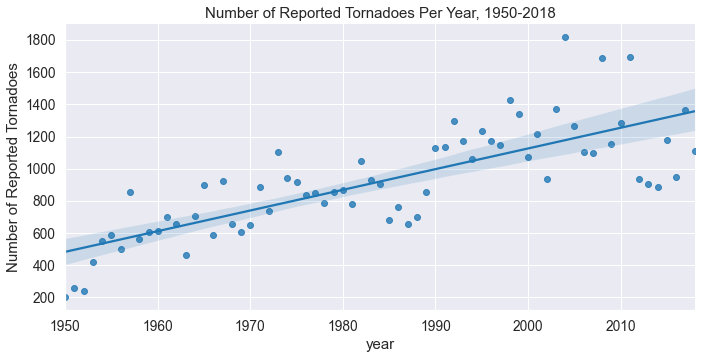

In [11]:
yearly_counts = (tornado_df.observation_year.value_counts().to_frame().reset_index(drop=False).rename(columns={'index': 'year', 'observation_year': 'number_of_reported_tornadoes'}))
g = sns.lmplot('year', 'number_of_reported_tornadoes', data=yearly_counts, height=5, aspect=2);
g.set(title='Number of Reported Tornadoes Per Year, 1950-2018', ylabel='Number of Reported Tornadoes');
plt.savefig('num_tors_1950-2018.png', bbox_inches='tight');

Looking at this plot, it sure looks like the total number of tornadoes per year have been increasing since 1950! That's a really interesting find, let's see if the same holds true for the number of tornadoes per year for each F/EF scale value:

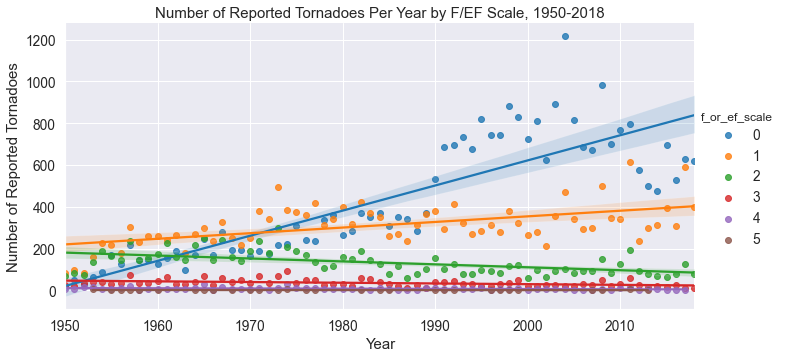

In [12]:
yearly_ef_tornado_count = (tornado_df.groupby(['observation_year', 'f_or_ef_scale'])
                                  .observation_valid_time
                                  .agg(['count'])
                                  .reset_index(drop=False)
                                  .rename(columns={'count': 'number_of_reported_tornadoes'}))
g = sns.lmplot('observation_year', 'number_of_reported_tornadoes',
           hue='f_or_ef_scale', data=yearly_ef_tornado_count, height=5, aspect=2);
g.set(title='Number of Reported Tornadoes Per Year by F/EF Scale, 1950-2018', ylabel='Number of Reported Tornadoes', xlabel='Year');
plt.savefig('num_tors_by_ef_category_1950-2018.png', bbox_inches='tight');

The above plot shows a flat trend for E/F 3, 4, and 5 tornadoes, a decreasing trend for E/F 2 tornadoes, a modest increasing trend for E/F 1 tornadoes, and an insane increasing trend for E/F 0 tornadoes. The specific datapoints on the plot show that this upward trend began around 1990, so what's the deal?

There's been some great research done on the topic of the quality of this historical tornado reports dataset, all of which I can't do justice to in this post. I'll attempt to summarize the causes of this spurrious trend described in greater detail in [Doswell and Burgess (1988)](https://journals.ametsoc.org/doi/10.1175/WAF910.1#), [Grazulis 1993](https://journals.ametsoc.org/doi/10.1175/WAF910.1#), [Brooks and Doswell (2001)](https://journals.ametsoc.org/doi/10.1175/WAF910.1#), and [Verbout 2005](https://journals.ametsoc.org/doi/10.1175/WAF910.1):

- As the population increases and people move into formerly unpopulated regions, the number of tornadoes that occurred _and_ were observed has increased.
- The popularity of storm chasing and the creation of storm spotting training sessions and network has likely resulted in an increase in tornado reporting.
- The NEXRAD Doppler radar network from NOAA has allowed for weaker tornado velocity signatures to be identified.

If we plot the timeseries of yearly tornadoes for each E/F Scale value from 1980 and also when the first Doppler radar was installed, we confirm that almost all of the upward trend of tornado reports is due to these E/F 0 reports:

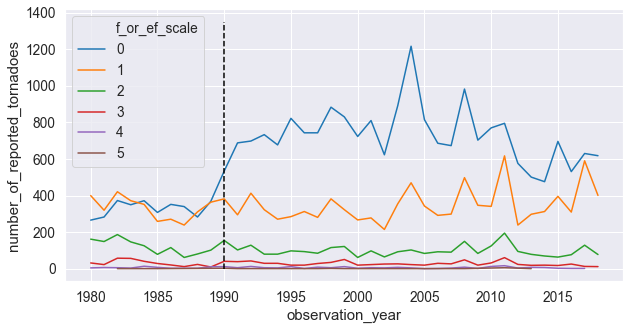

In [13]:
_, ax = plt.subplots(figsize=(10, 5))

ef_tornado_count_since_1980 = yearly_ef_tornado_count.loc[yearly_ef_tornado_count.observation_year >= 1980].assign(f_or_ef_scale=lambda x: pd.Categorical(x.f_or_ef_scale))

ax = sns.lineplot('observation_year', 'number_of_reported_tornadoes',
                 hue='f_or_ef_scale', data=ef_tornado_count_since_1980, ax=ax);
ax.plot(np.ones(10) * 1990, np.arange(0, 1500, 150), '--k');
plt.savefig('num_tors_by_ef_category_ts_1980-2018.png', bbox_inches='tight');

We have two options to account for this, neither of which is ideal:

1. Keep only E/F 1 and greater tornadoes,
2. Keep all tornadoes regardless of E/F scale, but only use data from 1990 to present.

Since we already have so few tornado reports, I go with the second option. That said, we'll also show future results when only using E/F 1+ tornadoes.


In [14]:
tornado_df = tornado_df.loc[(tornado_df.observation_year >= 1990) & (tornado_df.f_or_ef_scale >= 1)]

Now, let's save this file as a csv and call it a day!

In [15]:
tornado_df.to_csv('../data/cleaned_tornado_reports.csv', index=False)

Great, we now have a (relatively) cleaned dataset of tornado reports! Let's say, instead of doing all of this within a Jupyter notebook, we wanted to run all of this data cleaning within a script, we ought to write functions to do this (something I _definitely_ didn't do in grad school), so let's do that right now. This also can be used on the command line via click (which I've added to `redissertation/data.py`):

In [16]:
from typing import List, Dict


SPC_REPORT_RENAME_DICT = {'yr': 'observation_year', 'mo': 'observation_month',
               'dy': 'observation_date', 'tz': 'timezone',
               'st': 'observation_state', 'mag': 'f_or_ef_scale',
               'slat': 'starting_latitude_deg',
               'slon': 'starting_longitude_deg',
               'elat': 'ending_latitude_deg',
               'elon': 'ending_longitude_deg'}


def get_tornado_reports(url_or_path: str, date_and_time_columns: List[str]=['date', 'time'],
                        column_rename_and_keep_dict: Dict[str, str]=SPC_REPORT_RENAME_DICT) -> pd.DataFrame:
    """Get and preprocess SPC tornado reports data."""
    df = (pd.read_csv(url_or_path,
                      parse_dates={'observation_datetime': date_and_time_columns})
            .rename(columns=column_rename_and_keep_dict)
            .loc[:, list(column_rename_and_keep_dict.values()) + ['observation_datetime',]])
    return df


def drop_unknown_f_or_ef_scales(df: pd.DataFrame, f_or_ef_scale_column: str, unknown_scale_id: int=-9) -> pd.DataFrame:
    """Drop observations with unknown E/F Scale values."""
    return df.loc[df[f_or_ef_scale_column] != unknown_scale_id].reset_index(drop=True)


def filter_by_year(df: pd.DataFrame, datetime_column: str, earliest_year_for_obs: int) -> pd.DataFrame:
    """Filter tornado reports data based on some start year."""
    return df.loc[df[datetime_column].dt.year >= earliest_year_for_obs]


def find_valid_time(df: pd.DataFrame, observation_time_column: str,
                    valid_time_column: str='observation_valid_time') -> pd.DataFrame:
    """Match up observed tornadoes with a valid time (12z-12z).

    Create the valid times of the reports, e.g. the "day" to which
    they are associated. We consider the "valid time" to be the
    ending time of a 24 hour forecast period. For example, a tornado
    occurring at 2016-05-18 05:00Z would have a valid time of
    2016-05-18 12:00Z, and a tornado occurring at 2016-05-18 15:00Z
    would have a valid time of 2016-05-19 12:00Z.
    """
    valid_times = (df.observation_datetime + pd.Timedelta('6H')).dt.ceil('12H')
    valid_times = valid_times.where(valid_times.dt.hour != 0, valid_times + pd.Timedelta('12H'))
    df = df.assign(**{valid_time_column: valid_times})
    return df


def filter_non_central_time_reports(df: pd.DataFrame, timezone_column: str,
                                    timezone_to_keep: int=3) -> pd.DataFrame:
    """Filter out tornado reports that weren't logged in CST."""
    return df.loc[df[timezone_column] == timezone_to_keep]


def get_clean_and_save_tornado_reports(save_path, csv_save_name, spc_tor_url):
    df = get_tornado_reports(spc_tor_url)
    df = (df.pipe(drop_unknown_f_or_ef_scales, 'f_or_ef_scale')
            .pipe(filter_non_central_time_reports, 'timezone')
            .pipe(filter_by_year, 'observation_datetime', 1990)
            .pipe(find_valid_time, 'observation_datetime'))
    df.reset_index(drop=True).to_csv(os.path.join(save_path, csv_save_name), index=False)